##  <a href=#1 id="z1" style="color: #000000;text-decoration: none;">1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.</a>


##  <a href=#2 id="z2" style="color: #000000;text-decoration: none;">2.Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.</a>

## <a href=#3 id="z3" style="color: #000000;text-decoration: none;">3. Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени</a>

In [2]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [350]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 2

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

### <div id=1>1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.</div>
<div style="text-align:right;"><a href=#z1 style="color: #000000;"><button style="color: bleak;">наверх...</button></a></div>

In [357]:
def grid_gb_fit(X_train, X_test, y_train, y_test, eta=1, n_trees=3, max_depth=3):   
   
    """   
       Функция, кроме того, что она запускает обучение, она еще 
       подготавливает данные так, чтоб на их основе было возможно 
       построить графики ошибок.
    """
    n_trees, max_depth = np.meshgrid(np.linspace(2, n_trees, n_trees-1), np.linspace(2, max_depth, max_depth-1))
    n_trees = n_trees.astype(int)
    max_depth = max_depth.astype(int)    
    z_test_errors = np.empty_like(n_trees,dtype=int)
    z_train_errors = np.empty_like(n_trees,dtype=int)
    
    for i in range(n_trees.shape[0]):
        for j in range(n_trees.shape[1]):       
            trees, train_errors, test_errors = gb_fit(n_trees[i,j], max_depth[i,j], X_train, X_test, y_train, y_test, eta)
            z_test_errors[i,j] = test_errors[-1]
            z_train_errors[i,j] = train_errors[-1]
    return z_test_errors, z_train_errors, n_trees, max_depth

In [316]:
def min_test_error(z):
    """
    Функция предназначена для поиска минимального значения в списке массивов координатных сеток.
    """
    z_min = z[:,1:].min()
    r = np.where(z == z_min)#
    i = r[0][0]
    j = r[1][0]
    x = n_trees[i,j]
    y = max_depth[i,j] 
   # print(f'x = {x}, y = {y}')
    return x,y,z_min,i,j

In [295]:
def plot_err():
    """
    Функция строит графики 
    """
    plt.figure(figsize=(16, 30))       
    def r(r,c,i,n_trees, max_depth,z,ylabel="",eta=1,label=""):
        x,y,z_min,*ij = min_test_error(z)
        plt.subplot(r, c, i)    
        cont = plt.contour(n_trees, z, max_depth, levels=max_depth[:,0])
        #plt.yscale('log')
        plt.clabel(cont, inline=5, fontsize=10)
        plt.plot(x, z.min(),'ro', ms=8)
        plt.xlim(n_trees.min()-1,n_trees.max()+1)
        plt.ylim(z.min()-500,z.max()+500)
        plt.xticks(n_trees[0])
        plt.grid("grid=x")
        
        plt.text(x,z.min(),label,fontsize=14, bbox={'facecolor':'yellow','alpha':0.2})
        plt.title(f'eta = {eta:0.1f}')
        plt.xlabel("Количество деревьев")
        plt.ylabel(ylabel)
        return 
    return r
    

Построим графики как линии уровня параметра max_depth глубина деревьев, отражающих зависимость ошибки от параметра n_trees количество деревьев. Графики варьируются по параметру eta. 

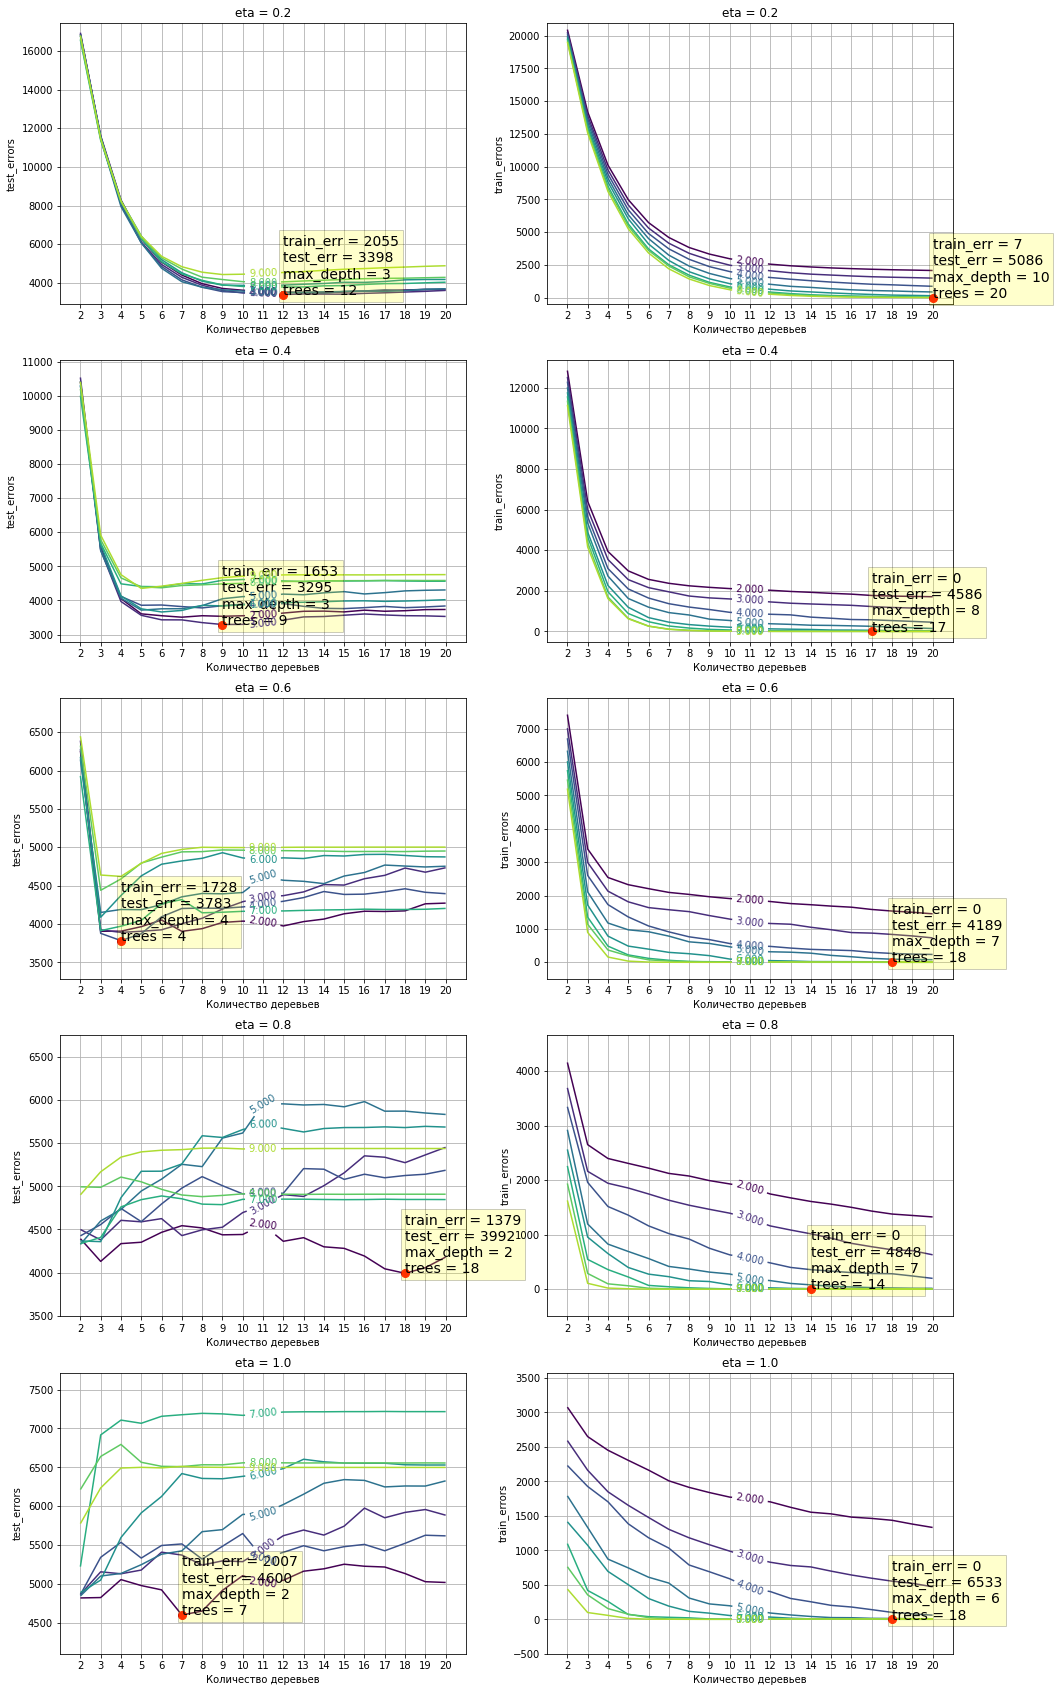

In [301]:
pl = plot_err()
eta = np.linspace(0.2,1,5)
n = 0
for i, item_eta in enumerate(eta):    
    z, z_train_errors, n_trees, max_depth = grid_gb_fit(X_train, X_test, y_train, y_test, eta=item_eta, n_trees=20, max_depth=10)
    
    n_tree,n_depth,test_error_min,i,j = min_test_error(z)    
    train_error = z_train_errors[i,j]    
    label = f'train_err = {train_error}\ntest_err = {test_error_min}\nmax_depth = {n_depth}\ntrees = {n_tree}'    
    ylabel = "test_errors"  
    
    n += 1
    pl(5, 2, n, n_trees, max_depth, z, ylabel, item_eta,label)
    
    n_tree,n_depth,train_error_min,i,j = min_test_error(z_train_errors)    
    test_error = z[i,j]    
    label = f'train_err = {train_error_min}\ntest_err = {test_error}\nmax_depth = {n_depth}\ntrees = {n_tree}' 
        
    n += 1
    ylabel = "train_errors"
    pl(5, 2, n,n_trees, max_depth, z_train_errors, ylabel, item_eta,label)
    
    

С целью лучшего отображения линий уровня зависимости ошибки от глубины и количества дерева графики строятся при количестве деревьев начиная с 2. На всех графиках начальная ошибка(при n_trees=1) высокая из-за чего меняется масштаб, что приводит к "схлопыванию" расстояний между линиями.

Выводы по графикам. Из графиков отображающих ошибку test_errors видно, что ошибка тем больше, чем больше глубина деревьев. На всех графиках test_errors варьированных по параметру eta минимум достигается при глубине деревьев равным 2м. Так же заметно, что при eta = 0.2 график плавно сходится к минимуму, чего не скажешь про график где eta = 1, где с ростом количества деревьев график "блуждает".

Среди построенных графиков можно отыскать лучший, но не один не показал приемлемо допустимых значений ошибок.

Вывод: при количестве деревьев до 20 и глубине до 10 и  eta до 1
модель не до обучилась.

### <div id=2>2.Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.</div>
<div style="text-align:right;"><a href=#z1 style="color: #000000;"><button style="color: bleak;">наверх...</button></a>

In [317]:
X, y = load_diabetes(return_X_y=True)

In [318]:
def gb_fit(n_trees, max_depth, X, y, eta):
    
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5)
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [319]:
def grid_gb_fit(X, y, eta=1, n_trees=3, max_depth=3):
   
    n_trees, max_depth = np.meshgrid(np.linspace(2, n_trees, n_trees-1), np.linspace(2, max_depth, max_depth-1))
    n_trees = n_trees.astype(int)
    max_depth = max_depth.astype(int)    
    z_test_errors = np.empty_like(n_trees,dtype=int)
    z_train_errors = np.empty_like(n_trees,dtype=int)
    
    for i in range(n_trees.shape[0]):
        for j in range(n_trees.shape[1]):       
            trees, train_errors, test_errors = gb_fit(n_trees[i,j], max_depth[i,j], X, y, eta)
            z_test_errors[i,j] = test_errors[-1]
            z_train_errors[i,j] = train_errors[-1]
    return z_test_errors, z_train_errors, n_trees, max_depth

In [320]:
def plot_err():
    plt.figure(figsize=(16, 30))       
    def r(r,c,i,n_trees, max_depth,z,ylabel="",eta=1,label=""):
        x,y,z_min,*ij = min_test_error(z)
        plt.subplot(r, c, i)    
        cont = plt.contour(n_trees, z, max_depth, levels=max_depth[:,0])
        #plt.yscale('log')
        plt.clabel(cont, inline=5, fontsize=10)
        plt.plot(x, z.min(),'ro', ms=8)
        plt.xlim(n_trees.min()-1,n_trees.max()+1)
        plt.ylim(z.min()-500,z.max()+500)
        plt.xticks(n_trees[0])
        plt.grid("grid=x")
        
        plt.text(x,z.min(),label,fontsize=14, bbox={'facecolor':'yellow','alpha':0.2})
        #plt.text(x,z.min(),f'err = {z_min}\nmax_depth = {y}\ntrees = {x}',fontsize=14, bbox={'facecolor':'yellow','alpha':0.2})

        plt.title(f'eta = {eta:0.1f}')
        plt.xlabel("Количество деревьев")
        plt.ylabel(ylabel)
        return 
    return r

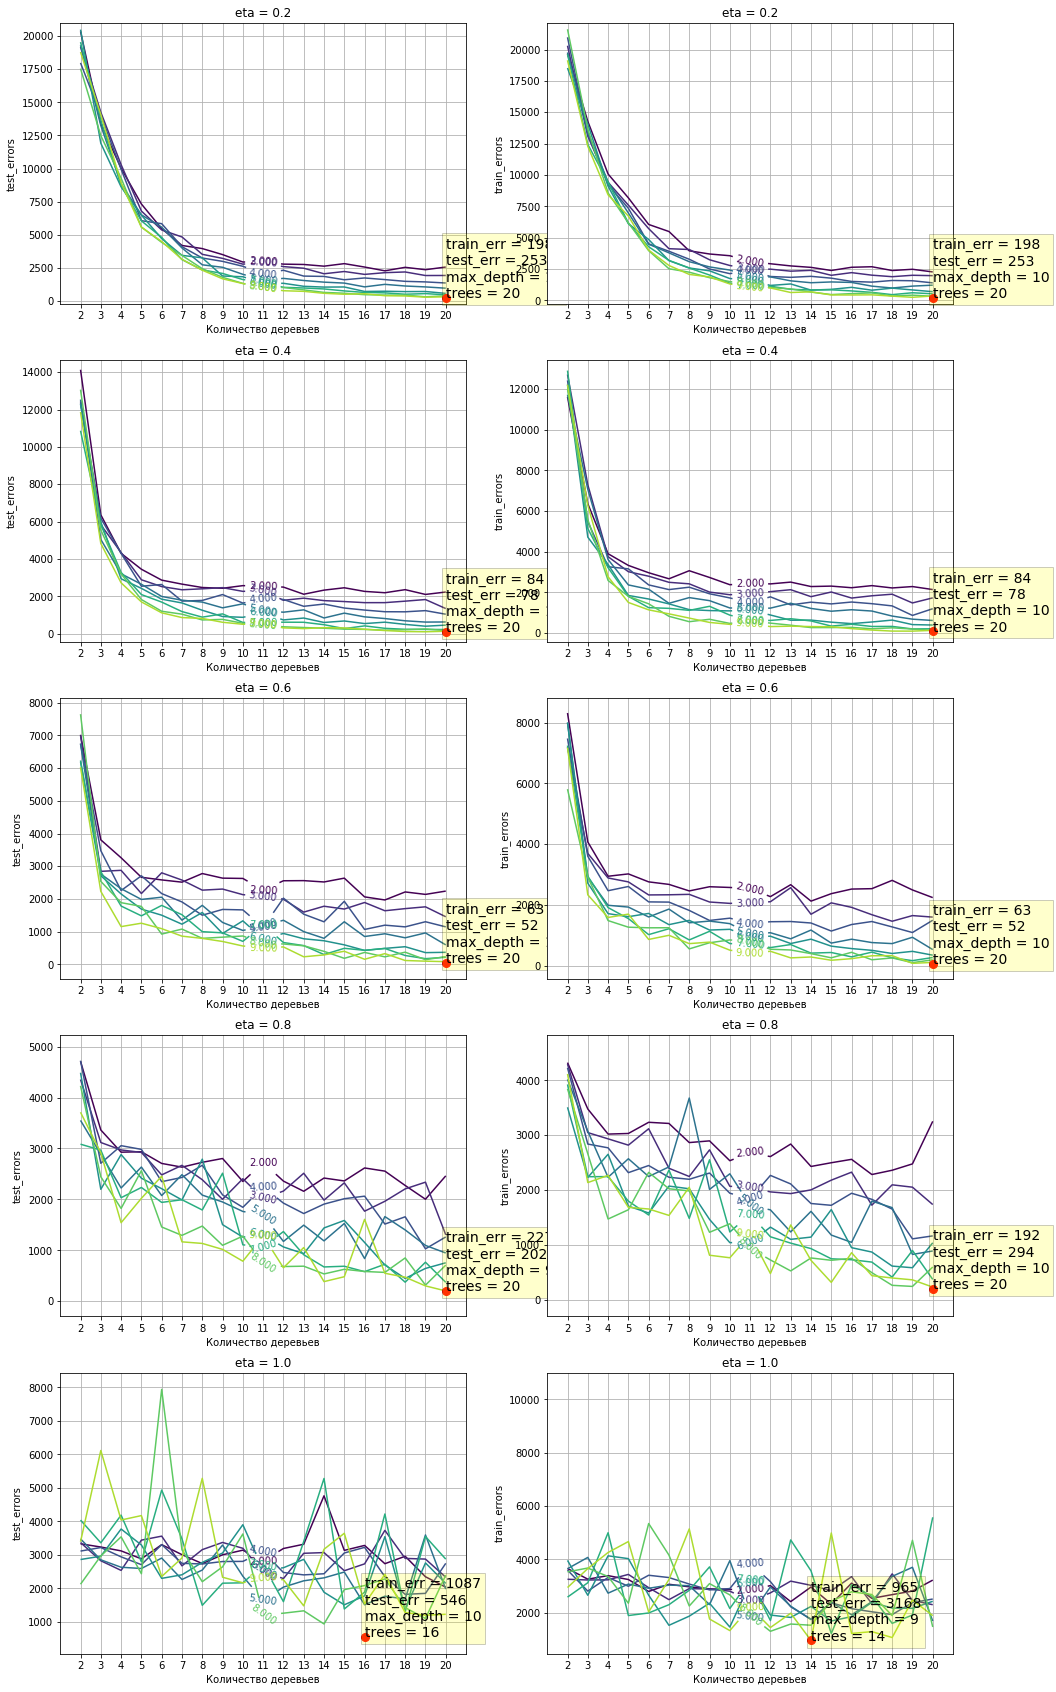

In [325]:
pl = plot_err()
eta = np.linspace(0.2,1,5)
n = 0
for i, item_eta in enumerate(eta):    
    z, z_train_errors, n_trees, max_depth = grid_gb_fit(X, y, eta=item_eta, n_trees=20, max_depth=10)
    
    n_tree,n_depth,test_error_min,i,j = min_test_error(z)    
    train_error = z_train_errors[i,j]    
    label = f'train_err = {train_error}\ntest_err = {test_error_min}\nmax_depth = {n_depth}\ntrees = {n_tree}'    
    ylabel = "test_errors"  
    
    n += 1
    pl(5, 2, n, n_trees, max_depth, z, ylabel, item_eta,label)
    
    n_tree,n_depth,train_error_min,i,j = min_test_error(z_train_errors)    
    test_error = z[i,j]    
    label = f'train_err = {train_error_min}\ntest_err = {test_error}\nmax_depth = {n_depth}\ntrees = {n_tree}' 
        
    n += 1
    ylabel = "train_errors"
    pl(5, 2, n,n_trees, max_depth, z_train_errors, ylabel, item_eta,label)
    

Стохастический градиентный бустинг. Превзошёл мои ожидания по сравнению с простым градиентным бустингом, так как при тех же параметрах обучения(количество деревьев до 20, глубина до 10, eta до 1) величина ошибок снизилась на несколько порядков. Хорошие показатели достигаются при значениях eta до 0.8 включительно, n_trees = 20, max_depth = 10, то есть на границах заданных параметров.

Вывод: алгоритм со своей задачей справился, ошибки минимальны. 

### <div id=3>3.3. Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.</div>
<div style="text-align:right;"><a href=#z1 style="color: #000000;"><button style="color: bleak;">наверх...</button></a>

Для оптимизации алгоритма обучения необходимо процесс расчета ошибки вынести в отдельную функцию(вынесено в функцию get_errors), которой следует воспользоваться вне функции реализующей алгоритм обучения. Сравнивая скорости обучения до и после при n_trees = 20, max_depth = 10, eta = 0.6 производительность возросла в 3 раза. 

In [354]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree.fit(X_train, y_train)
    
    for i in range(n_trees-1):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        # Получим ответы на текущей композиции
        target = gb_predict(X_train, trees, eta)
        # алгоритмы начиная со второго обучаем на сдвиг
        tree.fit(X_train, residual(y_train, target))      
        trees.append(tree)
        
    return trees

In [343]:
def get_errors(X_train, y_train, trees, eta):
    errors = []
    
    for i in range(1,len(trees)+1):
        errors.append(mean_squared_error(y_train, gb_predict(X_train, trees[:i], eta)))        
    return errors     

In [353]:
%%time
n_trees = 20
max_depth = 10
eta = 0.6
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 6.29 s


In [355]:
%%time
n_trees = 20
max_depth = 10
eta = 0.6
trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.96 s


In [359]:
6.29/1.9

3.310526315789474